In [2]:
# Load the fine tuned segformer model
from transformers import SegformerForSemanticSegmentation
model = 'gray' # gray, deoldify_part, deoldify_all
model_dir = f'./segformer_model/{model}'

id2label = {0: 'Non-Forest', 
            1: 'Forest',
            255: 'NoData'}
label2id = {'Non-Forest' : 0, 
            'Forest': 1,
            'NoData':255}

tranined_model = SegformerForSemanticSegmentation.from_pretrained(model_dir, num_labels=3)
tranined_model.eval()  # Set the model to evaluation mode

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [3]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, mode="test"):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            mode: Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        #self.feature_extractor = feature_extractor
        self.mode = mode
        self.transforms = self.create_transforms()
        
        #sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "input", self.mode)
        self.ann_dir = os.path.join(self.root_dir, "target", self.mode)
        self.images = sorted([f for _, _, files in os.walk(self.img_dir) for f in files])
        self.annotations = sorted([f for _, _, files in os.walk(self.ann_dir) for f in files])
        
    def create_transforms(self):
        _transforms = A.Compose([
            # A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0, mask_value=255),
            A.Resize(height=256, width=256), 
            ToTensorV2(),
#             A.Normalize([0.485, 0.456, 0.406, 0], [0.229, 0.224, 0.225, 1])
        ], p = 1,
        )
        return _transforms
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.img_dir, self.images[idx])))
        transformed = self.transforms(image=image)
        transformed_image = transformed["image"]

        mask  = np.array(Image.open(os.path.join(self.ann_dir, self.annotations[idx])).convert('L'))
        mask[mask > 1] = 255 #change all non-valid label value to 255

        return {"image": transformed_image, "mask": mask}

In [5]:
from torch.utils.data import DataLoader

data_dir = f'./Forest_{model}/'

test_dataset = SemanticSegmentationDataset(root_dir=data_dir,mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=1)

print(len(test_dataset))

602


/Users/alain/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/alain/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Sampler index: 16
OA: 1.0
Forest UA: nan
Non-Forest UA: 1.0
Forest PA: nan
Non-Forest PA: 1.0
Forest IoU: nan
Non-Forest IoU: 1.0


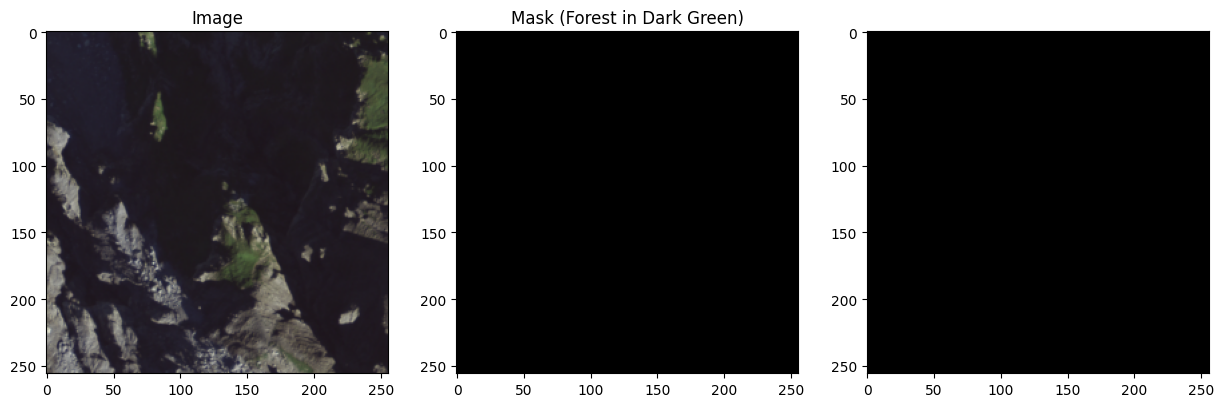



Sampler index: 83
OA: 0.9552764892578125
Forest UA: 0.9321149988856697
Non-Forest UA: 0.9673325444885269
Forest PA: 0.9369175627240144
Non-Forest PA: 0.964758422806368
Forest IoU: 0.8770708384012079
Non-Forest IoU: 0.9343178558623162


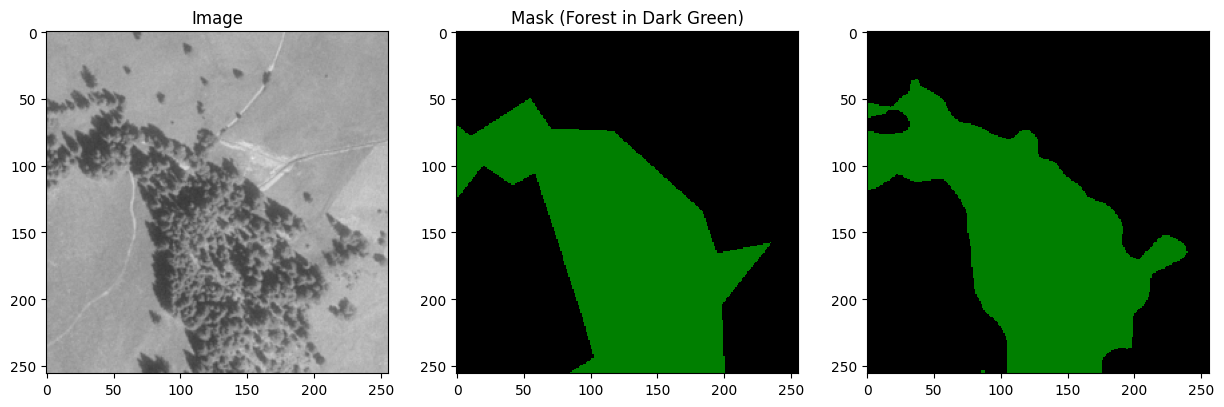



Sampler index: 98
OA: 0.9893646240234375
Forest UA: 0.9892608067104072
Non-Forest UA: 0.9918887601390498
Forest PA: 0.9996628780581777
Non-Forest PA: 0.7916152897657214
Forest IoU: 0.9889308855291576
Non-Forest IoU: 0.7865237366003063


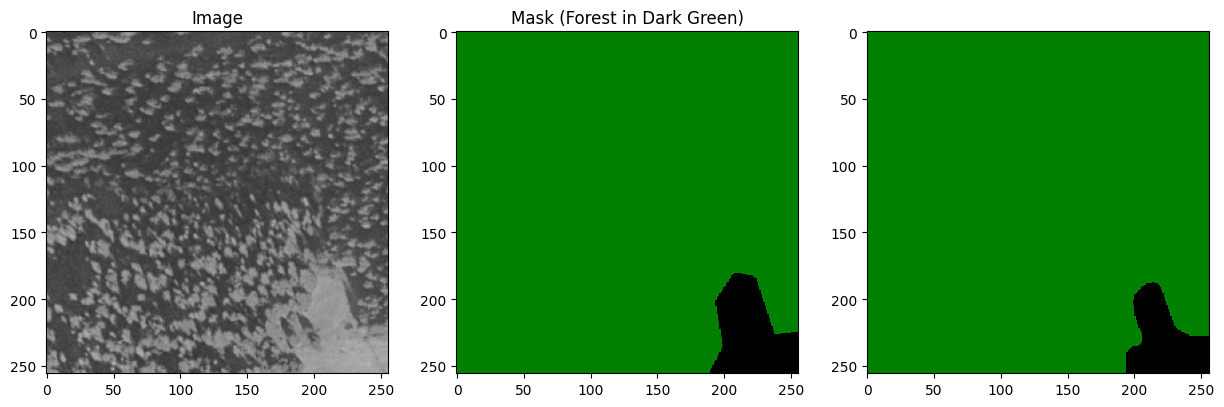



Sampler index: 139
OA: 0.9657192887931034
Forest UA: 0.986093935340585
Non-Forest UA: 0.9248823916232485
Forest PA: 0.9633848657445078
Non-Forest PA: 0.9707459516856916
Forest IoU: 0.9504719276053323
Non-Forest IoU: 0.8998031496062993


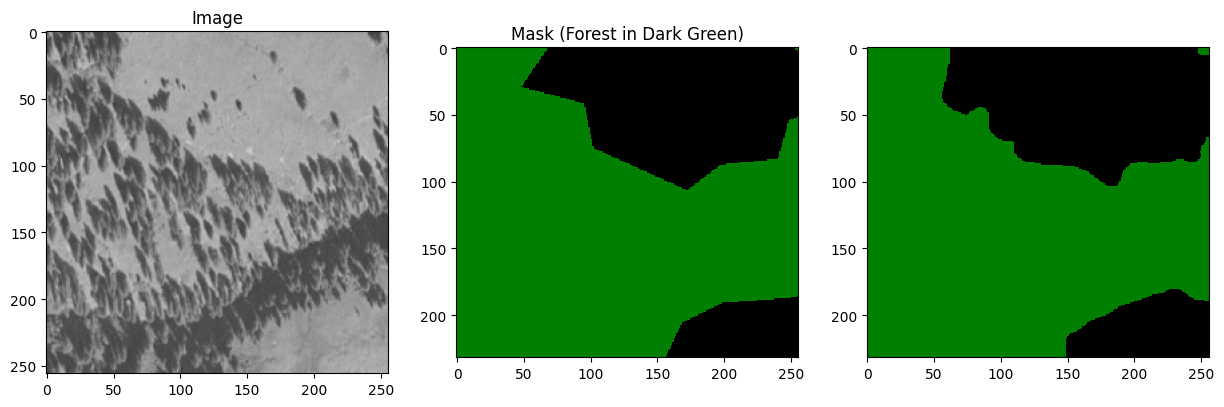



Sampler index: 513
OA: 0.0005149942558333004
Forest UA: nan
Non-Forest UA: 0.0005149942558333004
Forest PA: 0.0
Non-Forest PA: 1.0
Forest IoU: 0.0
Non-Forest IoU: 0.0005149942558333004


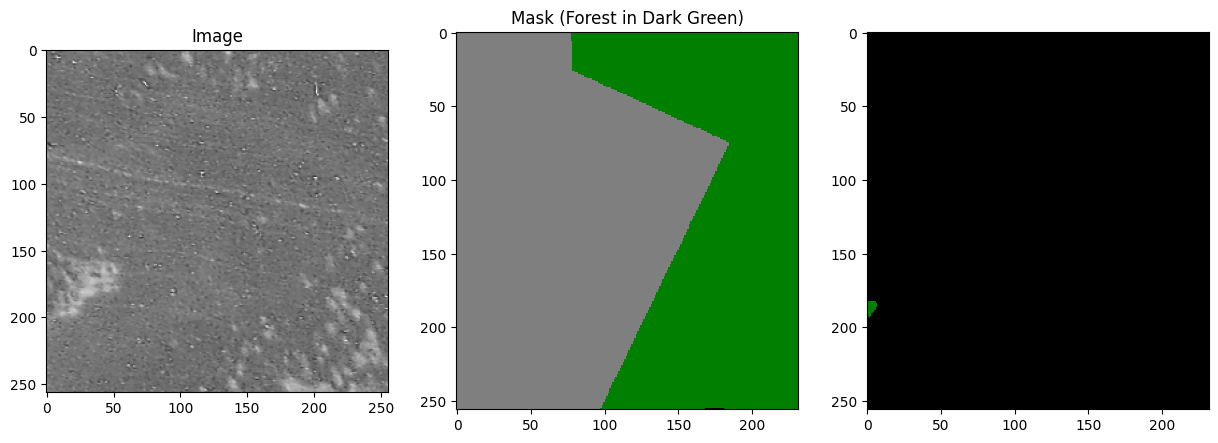

In [6]:
import torch
import random
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score
from datasets import load_metric
metric = load_metric("mean_iou")

def show_sample(image, mask, predicts):
    colors = [(0, 0, 0), (0,0.5,0), (0.5, 0.5, 0.5)]
    n_bins = [3]  # Discretizes the interpolation into bins
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=3)
    # Adjust mask for 'NoData' to be white or transparent
    mask_display = np.copy(mask)
    mask_display[mask == 255] = 2  # 2 corresponds to grey in the custom colormap
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.subplot(1, 3, 2)
    plt.imshow(mask_display, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    plt.title("Mask (Forest in Dark Green)")
    plt.subplot(1, 3, 3)
    plt.imshow(predicts, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    # plt.title("Predict  (Forest in Dark Green)")
    plt.show()

random_indices = random.sample(range(len(test_dataset)), 5)

for idx, batch in enumerate(test_dataloader):
    if idx in random_indices:
        # get the inputs;
        pixel_values = batch["image"].float()
        labels = batch["mask"].long()

        outputs = tranined_model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        # evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        metrics = metric._compute(references = labels.cpu(), 
                                  predictions = predicted.cpu(),
                                  num_labels=len(id2label), 
                                  ignore_index=255,
                                  reduce_labels=False, # we've already reduced the labels before)
        )

        OA = metrics["overall_accuracy"]
        forest_IoU = metrics["per_category_iou"][1]
        non_forest_IoU = metrics["per_category_iou"][0]
        forest_PA =  metrics["per_category_accuracy"][1]
        non_forest_PA =  metrics["per_category_accuracy"][0]

        # Compute the User accuracy manually
        num_Forest = int(torch.sum(labels.squeeze(0).eq(1)))
        num_Non_Forest = int(torch.sum(labels.squeeze(0).eq(0)))
        import math
        if math.isnan(forest_PA):
            F_F = 0
            F_NF = 0
            NF_NF = int(num_Non_Forest*non_forest_PA)
            NF_F = num_Non_Forest - NF_NF
        elif math.isnan(non_forest_PA):
            F_F = int(num_Forest*forest_PA)
            F_NF = num_Forest - F_F
            NF_F = 0
            NF_NF = 0
        else:
            F_F = int(num_Forest*forest_PA)
            F_NF = num_Forest - F_F
            NF_NF = int(num_Non_Forest*non_forest_PA)
            NF_F = num_Non_Forest - NF_NF
        forest_UA = np.nan if F_F+NF_F==0 else F_F/(F_F+NF_F)
        non_forest_UA = np.nan if F_NF+NF_NF == 0 else NF_NF/(F_NF+NF_NF)

        # Print loss and metrics for each class for one sample
        print('Sampler index:',idx)
        # print(F_F,F_NF,NF_F,NF_NF)
        print("OA:", OA)
        print("Forest UA:", forest_UA)
        print("Non-Forest UA:", non_forest_UA)
        print("Forest PA:", forest_PA)
        print("Non-Forest PA:", non_forest_PA)
        print("Forest IoU:", forest_IoU)
        print("Non-Forest IoU:", non_forest_IoU)
        
        pixel_values =  batch["image"].squeeze(0).permute(1, 2, 0)
        labels =  batch["mask"].squeeze(0)
        predicted = predicted.squeeze(0)

        pixel_values = pixel_values.to('cpu').numpy()
        labels = labels.to('cpu').numpy()
        predicted = predicted.to('cpu').numpy()
        show_sample(pixel_values, labels, predicted)
        print('\n')

In [7]:
all_F_F = []
all_F_NF = []
all_NF_F = []
all_NF_NF = []

mean_forest_IoU = []
mean_non_forest_IoU = []

for idx, batch in enumerate(test_dataloader):
    # get the inputs;
    pixel_values = batch["image"].float()
    labels = batch["mask"].long()
    outputs = tranined_model(pixel_values=pixel_values, labels=labels)
    loss, logits = outputs.loss, outputs.logits
    # evaluate
    with torch.no_grad():
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        # note that the metric expects predictions + labels as numpy arrays
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    # let's print loss and metrics every 100 batches
    metrics = metric._compute(references = labels.cpu(), 
                              predictions = predicted.cpu(),
                              num_labels=len(id2label), 
                              ignore_index=255,
                              reduce_labels=False, # we've already reduced the labels before)
    )

    OA = metrics["overall_accuracy"]
    forest_IoU = metrics["per_category_iou"][1]
    non_forest_IoU = metrics["per_category_iou"][0]
    forest_PA =  metrics["per_category_accuracy"][1]
    non_forest_PA =  metrics["per_category_accuracy"][0]
    # Compute the User accuracy manually
    num_Forest = int(torch.sum(labels.squeeze(0).eq(1)))
    num_Non_Forest = int(torch.sum(labels.squeeze(0).eq(0)))
    import math
    if math.isnan(forest_PA):
        F_F = 0
        F_NF = 0
        NF_NF = int(num_Non_Forest*non_forest_PA)
        NF_F = num_Non_Forest - NF_NF
    elif math.isnan(non_forest_PA):
        F_F = int(num_Forest*forest_PA)
        F_NF = num_Forest - F_F
        NF_F = 0
        NF_NF = 0
    else:
        F_F = int(num_Forest*forest_PA)
        F_NF = num_Forest - F_F
        NF_NF = int(num_Non_Forest*non_forest_PA)
        NF_F = num_Non_Forest - NF_NF
    all_F_F.append(F_F)
    all_F_NF.append(F_NF)
    all_NF_F.append(NF_F)
    all_NF_NF.append(NF_NF)
    mean_forest_IoU.append(forest_IoU)
    mean_non_forest_IoU.append(non_forest_PA)

all_F_F = np.sum(all_F_F)
all_F_NF = np.sum(all_F_NF)
all_NF_F = np.sum(all_NF_F)
all_NF_NF = np.sum(all_NF_NF)

total_OA = (all_F_F+all_NF_NF)/(all_F_F+all_F_NF+all_NF_F+all_NF_NF)
total_forest_UA = all_F_F/(all_F_F+all_NF_F)
total_non_forest_UA = all_NF_NF/(all_F_NF+all_NF_NF)
total_forest_PA = all_F_F/(all_F_F+all_F_NF)
total_non_forest_PA = all_NF_NF/(all_NF_F+all_NF_NF)

print("Mean OA:", total_OA)
print("Forest Mean UA:", total_forest_UA)
print("Non-Forest Mean UA:", total_non_forest_UA)
print("Forest Mean PA:", total_forest_PA)
print("Non-Forest Mean PA:", total_non_forest_PA)
print("Forest Mean IoU:", np.nanmean(mean_forest_IoU))
print("Non-Forest Mean IoU:", np.nanmean(mean_non_forest_IoU))
print("Overall Mean IoU:", ((np.nanmean(mean_forest_IoU))+np.nanmean(mean_non_forest_IoU))/2)


Mean OA: 0.9624397566930093
Forest Mean UA: 0.9243037125205387
Non-Forest Mean UA: 0.9814773745965268
Forest Mean PA: 0.9614061778820246
Non-Forest Mean PA: 0.962926434079182
Forest Mean IoU: 0.7312826038130363
Non-Forest Mean IoU: 0.8903642744791959
Overall Mean IoU: 0.8108234391461161
